# STEP 0 - Setup

## 0.1 - Import libraries to use

In [ ]:
import numpy as np
import pandas as pd
import os
from glob import glob
from PIL import Image
from tqdm import tqdm
import gc
from keras.backend import clear_session
from keras.callbacks import CSVLogger
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import array_to_img, img_to_array, load_img
from keras.utils.np_utils import to_categorical
from shutil import copytree as shutilCopyTree
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from typing import Tuple
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten
from tensorflow import keras
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn_evaluation.plot import ClassificationReport
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from random import randint
import matplotlib.pyplot as plt
%matplotlib inline

## 0.2 - Define Constants to Use

In [34]:
# Path constants
DATASET_PATH = './model/datasetHAM10000'
IMAGES_PATH  = f'{DATASET_PATH}/HAM10000_images_draft_v1'
TRAIN_PATH   = f'{DATASET_PATH}/train'
TEST_PATH    = f'{DATASET_PATH}/test'
MODEL_PATH   = f'{DATASET_PATH}/HAM10000_VGG16_nadam.h5'

# Utility Constants 
FIRST_RUN = False
IMAGE_WIDTH, IMAGE_HEIGHT = 256, 256
INPUT_SHAPE_W, INPUT_SHAPE_H, INPUT_SHAPE_CHANNELS = 128, 128, 3
GPU_MAX_MEMORY = 8 * 1024
TRAIN_IMAGES_SPLIT_SIZE = 40000

CLASSES = [
    'akiec',
    'bcc',
    'bkl',
    'df',
    'mel',
    'nv',
    'vasc'
]
CLASSES_FULLNAME = {
    "akiec" : "Bowen's Disease",
    "bcc"   : "Basal Cell Carcinoma" , 
    "bkl"   : "Benign Keratosis-like Lesions", 
    "df"    : "Dermatofibroma", 
    "mel"   : "Melanoma", 
    "nv"    : "Melanocytic Nevi", 
    "vasc"  : "Vascular Lesions", 
}

## 0.3 - Setup GPU for usage

In [ ]:
# Setup GPU for use
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        # Setup memory limit (8GB)
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=GPU_MAX_MEMORY)]
        )
        tf.config.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    raise Exception("No GPU found!")

# Step 1 - Data Preparation

## 1.1 - Data Preparation for End-2-End

In [ ]:
# Add image path location in metadata
def dataPrepE2E(metadata_filename, metadata_images_path):
    metadata = pd.read_csv(os.path.join(IMAGES_PATH, metadata_filename))
    
    # if we combine data into one directory then no need to mention *
    image_path = {os.path.splitext(os.path.basename(x))[0]: x
                  for x in glob(os.path.join(IMAGES_PATH, metadata_images_path, '*.jpg'))}
    if 'full' not in metadata_filename:
        metadata['path'] = metadata['image_id'].map(image_path.get)
    
    # Plot images W.R.T. for each class
    # dataPrepE2EPlot(metadata)
    metadata.info()
    
    return metadata

In [ ]:
# Plot images w.r.t. each category
def dataPrepE2EPlot(metadata):
    n_samples = 5  # number of samples for plotting
    
    # Plotting
    fig, m_axs = plt.subplots(
        7,
        n_samples,
        figsize = ( 4 * n_samples, 3 * 7 )
    )
    
    for n_axs, (type_name, type_rows) in zip(m_axs, metadata.sort_values(['dx']).groupby('dx')):
        n_axs[0].set_title(type_name)
        for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
            c_ax.imshow(c_row['image'])
            c_ax.axis('off')

## 1.2 - Data Augmentation & Image Generation

In [ ]:
# Preparation for the augmentation
def dataPrepAugmentation(path):
    img = load_img(
        path,
        target_size = (IMAGE_WIDTH, IMAGE_HEIGHT)
    )
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)
    return x

In [ ]:
# Augmentation image generator
def dataPrepAugmentationGenerator(input_image_array, output_dir, output_prefix):
    # Define data augmentation parameters
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    # Create an iterator to generate augmented images
    image_iterator = datagen.flow(
        x = input_image_array, 
        batch_size = 1, 
        save_to_dir = output_dir, 
        save_prefix = output_prefix, 
        save_format = 'jpg'
    )

    # Generate and save augmented images
    for _ in range(len(input_image_array)):
        image_batch = image_iterator.next()

In [ ]:
# Create new images to improve the dataset (First run only)
def dataPrepCreateNewImages(metadata):
    metadata_sorted = metadata.sort_values(['dx']).groupby('dx')
    metadata_groups = metadata_sorted.groups.items()
    metadata_images_to_create = {}

    for group in metadata_groups:
        # Create about ~6700 images per class
        metadata_images_to_create[group[0]] = max(0, 6700 - len(group[1]))
        
    new_metadata = {
        "lesion_id": [],
        "image_id": [],
        "dx": [],
        "dx_type": [],
        "age": [],
        "sex": [],
        "localization": [],
        "path": [],
    }

    for key, value in metadata_images_to_create.items():
        class_group = metadata_sorted.groups[key]
        unique_id = 0
        for i in range(value):
            image_row_index = class_group[randint(0, len(class_group) - 1)]
            input_image_array = dataPrepAugmentation(metadata['path'][image_row_index])
            image_path   = f'{IMAGES_PATH}/testing/{key}/'
            image_prefix = f'{key}_{unique_id}_' + metadata['image_id'][image_row_index]
            dataPrepAugmentationGenerator(
                input_image_array,
                image_path,
                image_prefix
            )
            
            for filename in os.listdir(image_path):
                if filename.startswith(image_prefix):
                    org_fp = os.path.join(image_path, filename)
                    new_fp = os.path.join(image_path, image_prefix + ".jpg")
                    os.rename(org_fp, new_fp)

            for metadata_col in new_metadata.keys():
                if (metadata_col == 'image_id'):
                    new_metadata[metadata_col].append(image_prefix)
                elif (metadata_col == 'path'):
                    new_metadata[metadata_col].append(new_fp)
                else:
                    new_metadata[metadata_col].append(metadata[metadata_col][image_row_index])

            unique_id += 1

    new_metadata_df = pd.DataFrame(data=new_metadata)
    new_metadata_df.to_csv(f'{IMAGES_PATH}/HAM10000_metadata_testing.csv', index = False)
    
    return new_metadata_df

In [ ]:
# Concat dataframes and create new "full" dataframe
def dataPrepConcatDataframes(original_metadata, new_metadata):
    metadata_full_df = pd.concat([original_metadata, new_metadata])
    metadata_full_df.info()
    metadata_full_df.to_csv(f'{IMAGES_PATH}/HAM10000_metadata_full.csv', index = False)

In [ ]:
# Create folder with all images
def dataPrepCreateFullFolder():
    src_folders = [
        f'{IMAGES_PATH}\\base_folders',
        f'{IMAGES_PATH}\\original',
        f'{IMAGES_PATH}\\testing',
    ]
    dst_folder = f'{IMAGES_PATH}\\full'

    # Create destination folder
    os.makedirs(os.path.dirname(dst_folder), exist_ok = True)
    
    # Copy content from source folders into destination folder
    for i in range(len(src_folders)):
        print(f'Copying {src_folders[i]} . . .')
        shutilCopyTree(src_folders[i], dst_folder, dirs_exist_ok = True)
        print(f'{src_folders[i]} copied into {dst_folder}!')

## 1.3 - Split Data Into Train & Test

In [ ]:
# Data split
def dataSplit(metadata):
    # metadata = dataEqualSamples(metadata, 1000)
    
    # train-test split for data preparation
    train, test = train_test_split(
        metadata,
        random_state = 42,
        stratify = metadata['dx'],
        test_size=0.20
    )
    
    # save train data into csv to overcome processing again & again (37549 records)
    train.to_csv(f'{DATASET_PATH}/skinDisease_train_main.csv')
    
    # save test data into csv to overcome processing again & again (9388 records)
    test.to_csv(f'{DATASET_PATH}/skinDisease_test_main.csv')
    
    return train, test

In [ ]:
# Equal samples on metadata
def dataEqualSamples(metadata, samples):
    # Equal all samples on metadata
    class_records_count = {}
    for key in CLASSES:
        class_records_count[key] = 0
    
    new_metadata = {
        "lesion_id": [],
        "image_id": [],
        "dx": [],
        "dx_type": [],
        "age": [],
        "sex": [],
        "localization": [],
        "path": [],
    }
    
    for i in range(len(metadata['dx'])):
        row = metadata.iloc[i]
        row_class = row['dx']
        
        if (class_records_count[row_class] > samples):
            continue
        
        class_records_count[row_class] += 1
        for metadata_col in new_metadata.keys():
            new_metadata[metadata_col].append(metadata[metadata_col][i])
    
    return pd.DataFrame(data=new_metadata)

# Step 2 - Get Data

## 2.1 - Get Train & Test Data

In [ ]:
# Get all train data
def getAllTrainData():
    train_df = pd.read_csv(f'{DATASET_PATH}/skinDisease_train_main.csv')
    return train_df

# Get all test data 
def getAllTestData():
    test_df = pd.read_csv(f'{DATASET_PATH}/skinDisease_test_main.csv')
    return test_df

## 2.2 - Created another DataFrame because we're not able to run fit model on all records, so created another DataFrame with less recods

In [ ]:
def getSplitTrainData(train_df):
    train_df_split = train_df[:TRAIN_IMAGES_SPLIT_SIZE]
    return train_df_split

# Step 3 - Use Data

## 3.1 - Convert images into numpy array and adding 1 extra dimension (batch) for CNN

In [ ]:
def convertTo4DArray(df):
    train_image = []
    for i in tqdm(range(df.shape[0])):
        img = load_img(
            df['path'][i],
            target_size=[
                INPUT_SHAPE_W,
                INPUT_SHAPE_H,
                INPUT_SHAPE_CHANNELS
            ]
        )
        img = img_to_array(img)
        img = img / 255.
        train_image.append(img)
    x = np.array(train_image)
    return x

## 3.2 - Apply encoder for Y the Training DataFrame

In [ ]:
def applyEncoderToLabel(df):
    y = df['dx'].values
    onehotencoder = OneHotEncoder(
        categories = 'auto',
        sparse_output = False
    )
    y = onehotencoder.fit_transform(y.reshape(-1, 1))
    return y

## 3.3 - Model Building & Training

In [ ]:
def modelBuildAndTraining(x, y, epochs):
    base_model = keras.applications.vgg16.VGG16(
        weights = "imagenet",
        include_top = False,
        input_shape = (INPUT_SHAPE_W, INPUT_SHAPE_H, INPUT_SHAPE_CHANNELS)
    )
    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(IMAGE_WIDTH, activation="relu"))
    model.add(Dense(7, activation="softmax"))
    
    for layer in base_model.layers:
        layer.trainable = False
    
    x_train, x_val, y_train, y_val = train_test_split(
        x,
        y,
        stratify = y,
        test_size = 0.20
    )
    model.compile(
        loss = "categorical_crossentropy",
        optimizer = "nadam",
        metrics = ["accuracy"]
    )
    model.summary()

    # Train the model
    csv_logger = CSVLogger(f'{MODEL_PATH}.log', separator=',', append=False)
    history = model.fit(
        x_train,
        y_train,
        epochs = epochs,
        validation_data = (x_val, y_val),
        verbose = 1,
        callbacks = [csv_logger],
    )
    
    model.save(MODEL_PATH)
    
    return history

## 3.4 - Summarize & Plot the Model

In [ ]:
def modelSummarize(history):
   # summarize history for accuracy
    drawPlot(
        history,
        'accuracy',
        'val_accuracy',
        "Model's accuracy",
        'Epoch',
        'Accuracy',
        ['train', 'test'],
        show_values = True,
        savefile = 'model_acc'
    )

    # summarize history for loss
    drawPlot(
        history,
        'loss',
        'val_loss',
        "Model's loss",
        'Epoch',
        'Loss',
        ['train', 'test'],
        savefile = 'model_loss'
    )

## 3.5 - (Optional) Load Model History

In [ ]:
def modelLoadHistory(model_path):
    log_data = pd.read_csv(model_path, sep=',', engine='python')
    return log_data

# Step 4 - Test Model

## 4.1 - Prepare test dataset

In [ ]:
def datasetPrepareForTest(df, x, y):
    train_image = []
    for i in tqdm(range(df.shape[0])):
        img = load_img(
            df['path'][i],
            target_size= [
                INPUT_SHAPE_W,
                INPUT_SHAPE_H,
                INPUT_SHAPE_CHANNELS
            ]
        )
        img = img_to_array(img)
        img = img/255.
        train_image.append(img)

    x_test = np.array(train_image)
    y_test = df['dx'].values
    onehotencoder = OneHotEncoder(categories='auto', sparse_output=False)
    y_test = onehotencoder.fit_transform(y_test.reshape(-1,1))
    return x_test, y_test

## 4.2 - Evaluate the model

In [ ]:
def modelEvaluate(x_test, y_test, model_path = MODEL_PATH):
    model = keras.models.load_model(model_path)
    print("Evaluate on test data")
    results = model.evaluate(
        x_test,
        y_test,
        batch_size=16
    )
    print(f"> Test loss {results[0]}\n> Test acc: {results[1]}")

## 4.3 - Predict the test data-testing

In [ ]:
def modelPredictTestData(x_test, model_path = MODEL_PATH):
    model = keras.models.load_model(model_path)
    y_pred = model.predict(
        x_test,
        batch_size=16
    )
    return y_pred

## 4.4 - Use model to predict an image

In [ ]:
def modelPredictImage(img_path, model_path = MODEL_PATH):
    model = keras.models.load_model(model_path)
    
    # prediction for single image
    img1 = load_img(
        img_path,
        color_mode='rgb',
        target_size=(INPUT_SHAPE_W, INPUT_SHAPE_H)
    )
    display(img1)
    x1 = img_to_array(img1)
    x1.shape
    
    # Adding the fouth dimension, for number of images
    x1 = np.expand_dims(x1, axis=0)
    x1 = preprocess_input(x1)
    features = model.predict(x1)
    
    class_prediction = {}
    for i in range(len(features[0])):
        class_prediction[CLASSES_FULLNAME[CLASSES[i]]] = f'{(features[0][i] * 100):.4f}%'
    
    print('************* class_prediction *************')
    printClassPrediction(class_prediction)
    
    MaxPosition = np.argmax(features)
    prediction_label = CLASSES_FULLNAME[CLASSES[MaxPosition]]
    print('************* prediction_label *************\n', prediction_label)
    
    return prediction_label

## 4.5 - Plot Confusion Matrix & Accuracy

In [ ]:
def confusionMatrixAndAccuracySummary(y_test, y_pred):
    rounded_labels = np.argmax(y_test, axis=1)
    y_pred_max = np.argmax(y_pred, axis=1)
    class_report = classification_report(rounded_labels, y_pred_max)
    
    printSection("Classification Report")
    print(class_report)
    
    class_rep_disp = ClassificationReport.from_raw_data(
        rounded_labels,
        y_pred_max,
        target_names = CLASSES
    )
    plt.tick_params(axis=u'both', which=u'both', length=0)
    plt.grid(visible=False)
    plt.show()
    
    printSection("Confusion Matrix")
    conf_mat = confusion_matrix(rounded_labels, y_pred_max)
    conf_mat_disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
    conf_mat_disp.plot()
    plt.tick_params(axis=u'both', which=u'both', length=0)
    plt.grid(visible=False)
    plt.show()

# Step 5 - Utility Scripts

In [ ]:
# Print a message to start & end a section 
def printSection(msg):
    max_len = 80
    msg_len = len(msg)
    dash_len = round((max_len - msg_len) / 2)
    
    print("-" * dash_len, msg, "-" * dash_len)

In [ ]:
# Plot for Accuracy & Loss Data
def drawPlot(history, x, y, title, xlabel, ylabel, legend, xlim = None, ylim = None, show_values = False, savefile = None):
    plt.grid(which='major', alpha=0.75)
    plt.minorticks_on()
    plt.grid(which='minor', alpha=0.5)
    plt.plot(history[x], marker='.')
    plt.plot(history[y], marker='.')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(legend, loc = 'upper left')
    
    if (xlim != None):
        plt.xlim(xlim)
        
    if (ylim != None):
        plt.ylim(ylim)
    
    if (show_values):
        for i in range(len(history[y])):
            plt.annotate(
                f'{(history[y][i] * 100):.1f}%',
                xy = (i, history[y][i] + .012),
                fontsize='x-small',
                horizontalalignment='center',
                alpha=.66,
            )

        for i in range(len(history[x])):
            plt.annotate(
                f'{(history[x][i] * 100):.1f}%',
                xy = (i, history[x][i] - .02),
                fontsize='x-small',
                horizontalalignment='center',
                alpha=.66,
            )
        
    if (savefile != None):
        plt.savefig(f'{DATASET_PATH}\\{savefile}.png')
    plt.show()

In [ ]:
def printClassPrediction(class_predictions):
    class_predictions_sorted = dict(
        sorted(
            class_predictions.items(),
            key=lambda x:x[1],
            reverse=True
        )
    )
    
    for key, value in class_predictions_sorted.items():
        print(f'{key}: {value}')

# Step 6 - First Run & Prepare Metadata

## 6.1 - Prepare Metadata and/or Generate Images For Usage

In [ ]:
if (FIRST_RUN):
    printSection('First run Data Prep Start')
    metadata = dataPrepE2E('HAM10000_metadata_original.csv', 'original/*/')
    printSection('Image Generation Start')
    new_metadata = dataPrepCreateNewImages(metadata)
    dataPrepConcatDataframes(metadata, new_metadata)
    # dataPrepCreateFullFolder()
    printSection('Image Generation complete')
    printSection('(First run) data preparation completed')
    
metadata = dataPrepE2E('HAM10000_metadata_full.csv', '/*/*/*/*/')
#dataPrepE2EPlot(metadata)
printSection("E2E data preparation complete")

## 6.2 - Split data into train & test .csv files

In [ ]:
dataSplit(metadata)
printSection("dataSplit complete")

## 6.3 - Preparate Data for Train

In [ ]:
# Get all train data
train_df = getAllTrainData()

# Get all test data 
test_df = getAllTestData()

printSection("Get train & test data complete")

# Get top N records
train_df_split = getSplitTrainData(train_df)
print(train_df_split['dx'].value_counts())

## 6.4 - Convert images into numpy array and adding 1 extra dimension (batch) for CNN (Convolutional Neural Network)

In [ ]:
printSection("convertTo4DArray start")
x = convertTo4DArray(train_df_split)
printSection("convertTo4DArray completed")

## 6.5 - Apply encoder for y

In [ ]:
y = applyEncoderToLabel(train_df_split)
printSection("Label encoding complete")

## 6.6 - Built & Summarize Model

In [ ]:
printSection("Model Construction and training start")

history = modelBuildAndTraining(x, y, 100)
modelSummarize(history.history)

# Housekeeping
del history
gc.collect()
clear_session()
    
printSection("Model Construction and training complete")

## 6.7 - Prepare test dataset & Evaluate the Model

In [ ]:
printSection("datasetPrepareForTest Start")
x_test, y_test = datasetPrepareForTest(test_df, x, y)
printSection("datasetPrepareForTest Complete")

printSection("Model Evaluation Start")
modelEvaluate(x_test, y_test)
printSection("Model Evaluation Complete")

## 6.8 - Predict & Test Model

In [ ]:
y_pred = modelPredictTestData(x_test)

printSection("confusionMatrixAndAccuracySummary Start")
confusionMatrixAndAccuracySummary(y_test, y_pred)
printSection("confusionMatrixAndAccuracySummary Complete")

del x_test
del y_test
del y_pred

## 6.9 - Test Predictions 

In [ ]:
printSection("Prediction Started")

model_path = f'{DATASET_PATH}/HAM10000_VGG16_nadam.h5'
img_path = f'{IMAGES_PATH}/original/bcc/ISIC_0025362.jpg'
modelPredictImage(img_path, model_path)

printSection("Prediction Complete")

# Step 7 - (Optional) Load Models to test predicitons

In [31]:
if True:
    # Get all train data
    train_df = getAllTrainData()

    # Get all test data 
    test_df = getAllTestData()

    printSection("Get train & test data complete")

    # Get top N records
    train_df_split = getSplitTrainData(train_df)
    print(train_df_split['dx'].value_counts())

    printSection("convertTo4DArray start")
    x = convertTo4DArray(train_df_split)
    printSection("convertTo4DArray completed")

    y = applyEncoderToLabel(train_df_split)
    printSection("Label encoding complete")

------------------------- Get train & test data complete -------------------------
dx
nv       5364
bkl      5360
mel      5360
df       5360
akiec    5360
vasc     5360
bcc      5360
Name: count, dtype: int64
----------------------------- convertTo4DArray start -----------------------------


100%|████████████████████████████████████████████████████████████████████████████| 37524/37524 [11:17<00:00, 55.38it/s]


--------------------------- convertTo4DArray completed ---------------------------
---------------------------- Label encoding complete ----------------------------


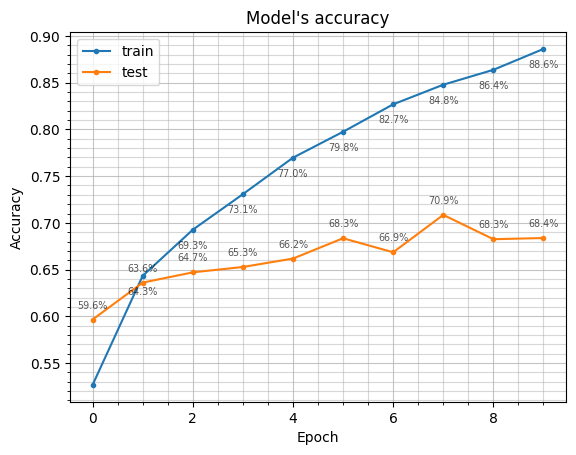

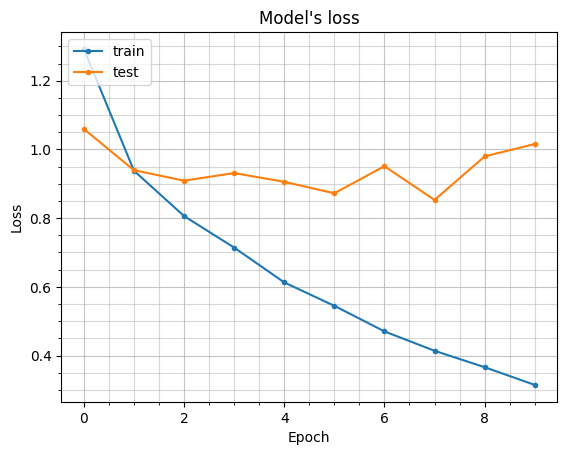

In [32]:
modelSummarize(history[:10])

-------------------------------- Model Load start --------------------------------


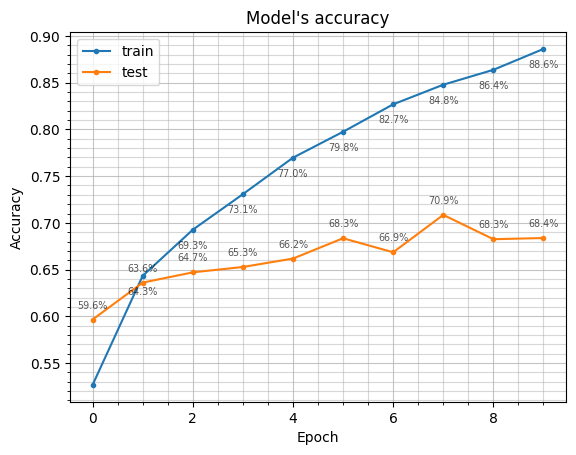

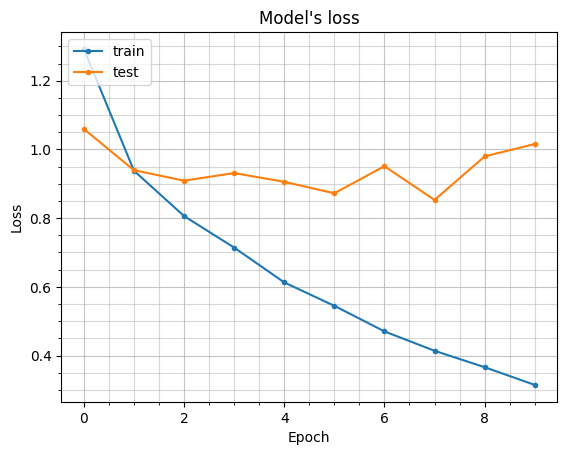

------------------------------ Model Load complete ------------------------------
-------------------------- datasetPrepareForTest Start --------------------------


100%|█████████████████████████████████████████████████████████████████████████████| 9381/9381 [00:11<00:00, 792.45it/s]


------------------------- datasetPrepareForTest Complete -------------------------
----------------------------- Model Evaluation Start -----------------------------
Evaluate on test data
587/587 [==============================] - 18s 17ms/step - loss: 0.7562 - accuracy: 0.7623
> Test loss 0.7561742067337036
> Test acc: 0.7622854709625244
---------------------------- Model Evaluation Complete ----------------------------
587/587 [==============================] - 9s 14ms/step
-------------------- confusionMatrixAndAccuracySummary Start --------------------
------------------------------ Classification Report ------------------------------
              precision    recall  f1-score   support

           0       0.75      0.63      0.69      1340
           1       0.60      0.88      0.72      1340
           2       0.63      0.60      0.61      1340
           3       0.94      0.74      0.83      1340
           4       0.66      0.72      0.69      1340
           5       0.89     

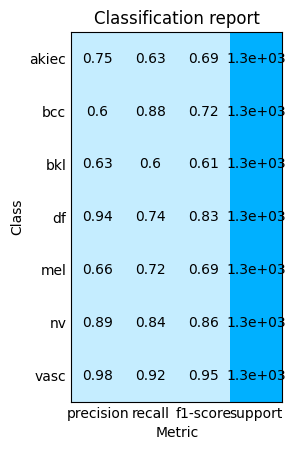

-------------------------------- Confusion Matrix --------------------------------


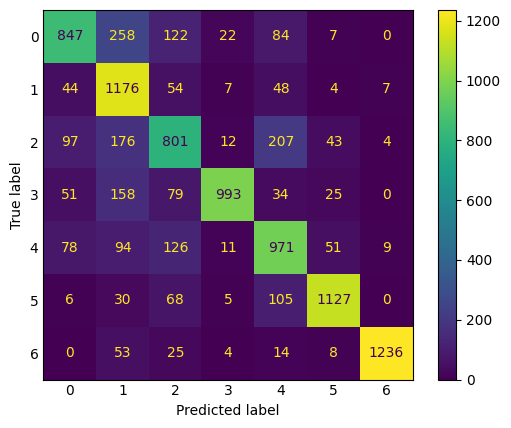

------------------- confusionMatrixAndAccuracySummary Complete -------------------


In [35]:
# Model Load
model_path = f'{DATASET_PATH}\\CompiledModels\\HAM10000_VGG16_nadam_72acc_v2\\HAM10000_VGG16_nadam.h5'
printSection("Model Load start")
history = modelLoadHistory(f'{model_path}.log')
modelSummarize(history)
printSection("Model Load complete")

# Testing
printSection("datasetPrepareForTest Start")
x_test, y_test = datasetPrepareForTest(test_df, x, y)
printSection("datasetPrepareForTest Complete")

printSection("Model Evaluation Start")
modelEvaluate(x_test, y_test, model_path = model_path)
printSection("Model Evaluation Complete")

y_pred = modelPredictTestData(x_test, model_path = model_path)

printSection("confusionMatrixAndAccuracySummary Start")
confusionMatrixAndAccuracySummary(y_test, y_pred)
printSection("confusionMatrixAndAccuracySummary Complete")